# Emotion and identity detection from face images
# Convolutional neural network

#### https://www.kaggle.com/c/facial-keypoints-detector
#### https://www.datascienceacademy.com.br/

In [5]:
# Imports
import os
import sys
import inspect
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from modulos import utils
from datetime import datetime
from tensorflow.python.framework import ops
from sklearn.metrics.classification import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings("ignore")

In [6]:
# TensorFlow version

# CPU: pip install tensorflow
# GPU: pip install tensorflow_gpu
tf.__version__

'1.12.0'

In [7]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
ops.reset_default_graph()
np.random.seed(123456789)

In [8]:
FLAGS = tf.flags.FLAGS
tf.flags.DEFINE_string("data_dir", "dataset/", "Caminho para o diretório com dados de treino e de teste")
tf.flags.DEFINE_string("logs_dir", "modelo/", "Caminho para o diretório onde o modelo será gravado")
tf.flags.DEFINE_string("mode", "train", "mode: train (Default)/ test")

In [9]:
# Hyperparâmetros
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
MAX_ITERATIONS = 1000
REGULARIZATION = 1e-3
IMAGE_SIZE = 48
NUM_LABELS = 7
VALIDATION_PERCENT = 0.1

### Funções Auxiliares Para Construção do Modelo

In [10]:
def add_to_regularization_loss(W, b):
    tf.add_to_collection("losses", tf.nn.l2_loss(W))
    tf.add_to_collection("losses", tf.nn.l2_loss(b))

In [11]:
def weight_variable(shape, stddev=0.02, name=None):
    initial = tf.truncated_normal(shape, stddev=stddev)
    if name is None:
        return tf.Variable(initial)
    else:
        return tf.get_variable(name, initializer=initial)

In [12]:
def bias_variable(shape, name=None):
    initial = tf.constant(0.0, shape=shape)
    if name is None:
        return tf.Variable(initial)
    else:
        return tf.get_variable(name, initializer=initial)

### Construção do Modelo

In [13]:
def emotionCNN(dataset):
    
    # Camada de Convolução 1
    with tf.name_scope("conv1") as scope:
        tf.summary.histogram("W_conv1", weights['wc1'])
        tf.summary.histogram("b_conv1", biases['bc1'])
        conv_1 = tf.nn.conv2d(dataset, weights['wc1'], strides=[1, 1, 1, 1], padding="SAME")
        h_conv1 = tf.nn.bias_add(conv_1, biases['bc1'])
        h_1 = tf.nn.relu(h_conv1)
        h_pool1 = tf.nn.max_pool(h_1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
        add_to_regularization_loss(weights['wc1'], biases['bc1'])

    # Camada de Convolução 2
    with tf.name_scope("conv2") as scope:
        tf.summary.histogram("W_conv2", weights['wc2'])
        tf.summary.histogram("b_conv2", biases['bc2'])
        conv_2 = tf.nn.conv2d(h_pool1, weights['wc2'], strides=[1, 1, 1, 1], padding="SAME")
        h_conv2 = tf.nn.bias_add(conv_2, biases['bc2'])
        h_2 = tf.nn.relu(h_conv2)
        h_pool2 = tf.nn.max_pool(h_2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")
        add_to_regularization_loss(weights['wc2'], biases['bc2'])

    # Camada Totalmente Conectada 1
    with tf.name_scope("fc_1") as scope:
        prob = 0.5
        image_size = IMAGE_SIZE // 4
        h_flat = tf.reshape(h_pool2, [-1, image_size * image_size * 64])
        tf.summary.histogram("W_fc1", weights['wf1'])
        tf.summary.histogram("b_fc1", biases['bf1'])
        h_fc1 = tf.nn.relu(tf.matmul(h_flat, weights['wf1']) + biases['bf1'])
        h_fc1_dropout = tf.nn.dropout(h_fc1, prob)
        
    # Camada Totalmente Conectada 2
    with tf.name_scope("fc_2") as scope:
        tf.summary.histogram("W_fc2", weights['wf2'])
        tf.summary.histogram("b_fc2", biases['bf2'])
        pred = tf.matmul(h_fc1_dropout, weights['wf2']) + biases['bf2']

    return pred

In [14]:
# Pesos e Bias do Modelo
weights = {
    'wc1': weight_variable([5, 5, 1, 32], name="W_conv1"),
    'wc2': weight_variable([3, 3, 32, 64],name="W_conv2"),
    'wf1': weight_variable([int((IMAGE_SIZE // 4) * (IMAGE_SIZE // 4)) * 64, 256],name="W_fc1"),
    'wf2': weight_variable([256, NUM_LABELS], name="W_fc2")
}

biases = {
    'bc1': bias_variable([32], name="b_conv1"),
    'bc2': bias_variable([64], name="b_conv2"),
    'bf1': bias_variable([256], name="b_fc1"),
    'bf2': bias_variable([NUM_LABELS], name="b_fc2")
}

In [15]:
def loss(pred, label):
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=label))
    tf.summary.scalar('Entropy', cross_entropy_loss)
    reg_losses = tf.add_n(tf.get_collection("losses"))
    tf.summary.scalar('Reg_loss', reg_losses)
    return cross_entropy_loss + REGULARIZATION * reg_losses

In [16]:
def train(loss, step):
    return tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss, global_step=step)

In [17]:
def get_next_batch(images, labels, step):
    offset = (step * BATCH_SIZE) % (images.shape[0] - BATCH_SIZE)
    batch_images = images[offset: offset + BATCH_SIZE]
    batch_labels = labels[offset:offset + BATCH_SIZE]
    return batch_images, batch_labels

In [18]:
# Listas para resultados de treinamento
train_error_list = []
train_step_list = []

# Listas para resultados de validação
valid_error_list = []
valid_step_list = []

### Treinamento

In [19]:
def main(argv=None):
    
    # Carrega os dados
    train_images, train_labels, valid_images, valid_labels, test_images = utils.read_data(FLAGS.data_dir)
    
    print("\nTamanho do Dataset de Treino: %s" % train_images.shape[0])
    print('Tamanho do Dataset de Validação: %s' % valid_images.shape[0])
    print("Tamanho do Dataset de Teste: %s" % test_images.shape[0])

    global_step = tf.Variable(0, trainable=False)
    dropout_prob = tf.placeholder(tf.float32)
    input_dataset = tf.placeholder(tf.float32, [None, IMAGE_SIZE, IMAGE_SIZE, 1], name="input")
    input_labels = tf.placeholder(tf.float32, [None, NUM_LABELS])

    pred = emotionCNN(input_dataset)
    output_pred = tf.nn.softmax(pred, name="output")
    loss_val = loss(pred, input_labels)
    train_op = train(loss_val, global_step)

    summary_op = tf.summary.merge_all()
    init_op = tf.global_variables_initializer()

    with tf.Session() as sess:
        sess.run(init_op)
        summary_writer = tf.summary.FileWriter(FLAGS.logs_dir, sess.graph)
        saver = tf.train.Saver()
        ckpt = tf.train.get_checkpoint_state(FLAGS.logs_dir)
        if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)
            print("Modelo Restaurado!")

        for step in range(MAX_ITERATIONS):
            batch_image, batch_label = get_next_batch(train_images, train_labels, step)
            feed_dict = {input_dataset: batch_image, input_labels: batch_label}

            sess.run(train_op, feed_dict=feed_dict)
            if step % 10 == 0:
                train_loss, summary_str = sess.run([loss_val, summary_op], feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, global_step=step)
                train_error_list.append(train_loss)
                train_step_list.append(step)
                print("Taxa de Erro no Treinamento: %f" % train_loss)

            if step % 100 == 0:
                valid_loss = sess.run(loss_val, feed_dict={input_dataset: valid_images, input_labels: valid_labels})
                valid_error_list.append(valid_loss)
                valid_step_list.append(step)
                print("%s Taxa de Erro na Validação: %f" % (datetime.now(), valid_loss))
                saver.save(sess, FLAGS.logs_dir + 'model.ckpt', global_step=step)
        
        # Plot do erro durante o treinamento
        plt.plot(train_step_list, train_error_list, 'r--', label='Erro no Treinamento Por Iteração', linewidth=4)
        plt.title('Erro no Treinamento Por Iteração')
        plt.xlabel('Iteração')
        plt.ylabel('Erro no Treinamento')
        plt.legend(loc='upper right')
        plt.show()

        # Plot do erro durante a validação
        plt.plot(valid_step_list, valid_error_list, 'r--', label='Erro na Validação Por Iteração', linewidth=4)
        plt.title('Erro na Validação Por Iteração')
        plt.xlabel('Iteração')
        plt.ylabel('Erro na Validação')
        plt.legend(loc='upper right')
        plt.show()  

print(train_error_list) 
print(valid_error_list) 

[]
[]



Tamanho do Dataset de Treino: 3761
Tamanho do Dataset de Validação: 417
Tamanho do Dataset de Teste: 1312
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Restoring parameters from modelo/model.ckpt-900
Modelo Restaurado!
Taxa de Erro no Treinamento: 0.347436
2018-12-03 10:12:33.174274 Taxa de Erro na Validação: 0.718865
Taxa de Erro no Treinamento: 0.153959
Taxa de Erro no Treinamento: 0.120037
Taxa de Erro no Treinamento: 0.163604
Taxa de Erro no Treinamento: 0.112930
Taxa de Erro no Treinamento: 0.141716
Taxa de Erro no Treinamento: 0.109278
Taxa de Erro no Treinamento: 0.105689
Taxa de Erro no Treinamento: 0.120556
Taxa de Erro no Treinamento: 0.140987
Taxa de Erro no Treinamento: 0.113844
2018-12-03 10:13:24.469362 Taxa de Erro na Validação: 0.687296
Taxa de Erro no Treinamento: 0.128049
Taxa de Erro no Treinamento: 0.147235

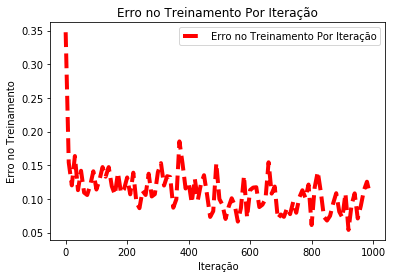

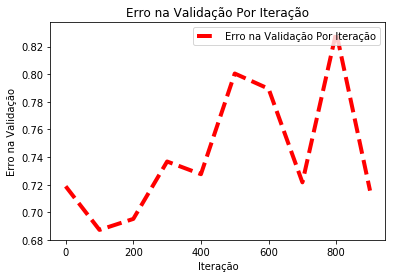

SystemExit: 

In [20]:
if __name__ == "__main__":
    tf.app.run()
    print("Treinanento concluído")